<a href="https://colab.research.google.com/github/jo313y/BREAKING_SAD/blob/main/Beer_Models_S3_connection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook contains the following order of operations:

1. Read in the data from S3 Bucket 
2. Process Data for an Unsupervised Machine Learning Algorithm
	- remove unnecessary columns and rows with NA values
	- scale the data
3. Reducing Data Dimensions Using PCA
4. Clustering Beer Using K-Means
6. Process data for supervised machine learning: a decision tree
	- remove unnecessary columns and rows with NA values
	- define the target vector (beer_style)
	- split into training and testing
	- scale x_train and x_test
7. Fit the Decision Tree Model
8. Make Predictions Using the Tree Model
9. Model Evaluation using the accuracy score
9. Reducing number of beer styles
	- manually by name
	- using binning based on frequency
	- using the unsupervised machine learning algorithm we built earlier

In [6]:
!source activate mlenv && conda env list

# Import dependencies for loading data
from sqlalchemy import create_engine
from sqlalchemy import inspect
import pandas as pd
import os

#Import dependencies for data celaning and visualization
import pandas as pd
import plotly.express as px
#import hvplot.pandas
!pip install hvplot holoviews

#Import dependencies for unsupervised learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Initial supervised learning
#from path import Path
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

/bin/bash: activate: No such file or directory


### 1. Import data from s3 Bucket

In [7]:
import os
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.0.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

In [8]:
# Download the Postgres driver that will allow Spark to interact with Postgres.
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2022-02-24 15:22:24--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar’

postgresql-42.2.16. 100%[===================>] 979.38K  2.80MB/s    in 0.3s    

2022-02-24 15:22:25 (2.80 MB/s) - ‘postgresql-42.2.16.jar’ saved [1002883/1002883]



In [9]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Beer_Analysis").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [10]:
from pyspark import SparkFiles
url = "https://e1-beerbucket.s3.us-east-2.amazonaws.com/clean_beer.csv"
spark.sparkContext.addFile(url)
full_table_df = spark.read.csv(SparkFiles.get(""), sep=",", header=True, inferSchema=True)
full_table_df.show()

+--------+-----------+-------------+--------------------+--------------------+-----------------+--------------+--------------+------------+------------------+------------+
|beer_ABV|beer_beerId|beer_brewerId|           beer_name|          beer_style|review_appearance|review_palette|review_overall|review_taste|review_profileName|review_aroma|
+--------+-----------+-------------+--------------------+--------------------+-----------------+--------------+--------------+------------+------------------+------------+
|     5.0|      47986|        10325|        Sausa Weizen|          Hefeweizen|              2.5|           2.0|           1.5|         1.5|           stcules|         1.5|
|     6.2|      48213|        10325|            Red Moon|  English Strong Ale|              3.0|           2.5|           3.0|         3.0|           stcules|         3.0|
|     6.5|      48215|        10325|Black Horse Black...|Foreign / Export ...|              3.0|           2.5|           3.0|         3.0| 

# Unsupervised Machine Learning

### 2. Process Data for an Unsupervised Machine Learning Algorithm

1. Null values are handled.

2. Only numerical data is used - binning and one hot coding will not be necessary for this dataset.

2. Values are scaled. In other words, data has been manipulated to ensure that the variance between the numbers won't skew results.

In [11]:
# Make pyspark table a pandas table
beer_table = full_table_df.toPandas()


In [105]:
# Make pandas table to dataframe
beer_df = pd.DataFrame(data=beer_table, index = beer_table.index)

In [106]:
# 1. Assign beer_style column to another variable for later
beer_style = beer_df.beer_style
print(beer_style.shape)
beer_style.head()

(508475,)


0                        Hefeweizen
1                English Strong Ale
2            Foreign / Export Stout
3                   German Pilsener
4    American Double / Imperial IPA
Name: beer_style, dtype: object

In [107]:
# 2. Drop columns we dont need:
beer_df =beer_df.drop(columns=["beer_beerId", "beer_brewerId", "beer_name", "beer_style", "review_profileName"])
beer_df.head()


,beer_ABV,review_appearance,review_palette,review_overall,review_taste,review_aroma
0,5.0,2.5,2.0,1.5,1.5,1.5
1,6.2,3.0,2.5,3.0,3.0,3.0
2,6.5,3.0,2.5,3.0,3.0,3.0
3,5.0,3.5,3.0,3.0,2.5,3.0
4,7.7,4.0,4.5,4.0,4.0,4.5


In [108]:
# 3. Drop rows with na values
beer_df = beer_df.dropna()

In [109]:
# 4. Check that all variables are numeric/float
beer_df.dtypes

beer_ABV             float64
review_appearance    float64
review_palette       float64
review_overall       float64
review_taste         float64
review_aroma         float64
dtype: object

In [110]:
# 5. Standardise the data
beer_scaled = StandardScaler().fit_transform(beer_df)

### 3. Reducing Data Dimensions Using PCA

PCA is a statistical technique to speed up machine learning algorithms when the number of input features (or dimensions) is too high. PCA reduces the number of dimensions by transforming a large set of variables into a smaller one that contains most of the information in the original large set.


In [111]:
# Using PCA to reduce dimension to three principal components.
# Initialize PCA model
pca = PCA(n_components=3)
# Get two principal components for the crypto_scaled data.
beer_pca = pca.fit_transform(beer_scaled)

In [112]:
# Create a DataFrame with the three principal components.
pcs_df = pd.DataFrame(data=beer_pca, columns=["PC 1", "PC 2", "PC 3"], index = beer_df.index)
len(pcs_df)
#pcs_df.head()

508475

### 4. Clustering Beer Using K-Means

#### Finding the Best Value for `k` Using the Elbow Curve

In [113]:
# Create an elbow curve to find the best value for K.

# Randlomy select 1000 rows from beer_df for viewing the elbow curve - 500,000 rows is too much to plot
pcs_trimmed_df = df = pcs_df.sample(n=1000)

inertia = []
k = list(range(1, 100))

# Calculate the inertia for the range of K values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pcs_trimmed_df)
    inertia.append(km.inertia_)

# Create the elbow curve
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
#df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")
fig = px.line(df_elbow, x="k", y="inertia", title='Elbow Curve')
fig.show()

In [114]:
# Initialize the K-Means model.
model = KMeans(n_clusters=9, random_state=0)

# Fit the model
model.fit(pcs_df)

# Predict clusters
predictions = model.predict(pcs_df)
len(predictions)

508475

In [115]:
# Create a new DataFrame including predicted clusters and cryptocurrencies features.
# Concatentate the crypto_df and pcs_df DataFrames on the same columns.
clustered_df = pd.concat([beer_df, pcs_df], axis=1, join='inner')

#  Add a new column, "beer_type" to the clustered_df DataFrame that holds the names of the Beers. 
clustered_df["beer_style"] = beer_style

#  Add a new column, "Class" to the clustered_df DataFrame that holds the predictions.
clustered_df["Class"] = model.labels_

# Print the shape of the clustered_df
print(clustered_df.shape)
clustered_df.head(10)


(508475, 11)


,beer_ABV,review_appearance,review_palette,review_overall,review_taste,review_aroma,PC 1,PC 2,PC 3,beer_style,Class
0,5.0,2.5,2.0,1.5,1.5,1.5,6.731175,0.635574,-0.326908,Hefeweizen,5
1,6.2,3.0,2.5,3.0,3.0,3.0,3.040082,0.088104,0.435684,English Strong Ale,8
2,6.5,3.0,2.5,3.0,3.0,3.0,3.012033,0.214500,0.463295,Foreign / Export Stout,8
3,5.0,3.5,3.0,3.0,2.5,3.0,2.851409,-0.257311,-0.483844,German Pilsener,8
4,7.7,4.0,4.5,4.0,4.0,4.5,-1.308323,0.147005,0.232782,American Double / Imperial IPA,0
5,4.7,3.5,3.5,3.0,3.0,3.5,1.890992,-0.490289,-0.242581,Herbed / Spiced Beer,8
6,4.7,3.5,3.5,3.5,4.0,4.0,0.573104,-0.938295,0.295053,Herbed / Spiced Beer,2
7,4.7,3.5,2.5,3.0,2.0,3.5,3.206626,-0.447056,-0.412057,Herbed / Spiced Beer,8
8,4.7,3.5,3.0,4.0,3.5,4.0,0.919320,-1.148925,0.412142,Herbed / Spiced Beer,2
9,4.7,5.0,3.5,4.5,4.0,4.0,-1.006172,-1.249811,-1.527743,Herbed / Spiced Beer,7


In [116]:
clustered_trimmed_df = df = clustered_df.sample(n=1000)
clustered_trimmed_df.head()

,beer_ABV,review_appearance,review_palette,review_overall,review_taste,review_aroma,PC 1,PC 2,PC 3,beer_style,Class
334237,6.8,4.0,4.0,4.0,3.5,4.0,-0.235710,-0.125600,-0.118925,Scottish Ale,7
141525,8.2,4.0,4.0,3.5,3.5,4.0,-0.055005,0.696494,-0.191900,American Double / Imperial IPA,0
22519,9.2,4.5,4.0,4.5,4.0,4.5,-1.758863,0.553950,-0.178388,Belgian Strong Pale Ale,6
419247,4.9,2.5,2.5,2.5,4.0,2.5,3.446931,-0.324185,0.823893,Dunkelweizen,8
327627,9.2,4.0,4.5,3.5,3.5,4.5,-0.799148,1.076628,0.093175,Dubbel,0


In [123]:
# Creating a 3D-Scatter with the PCA data and the clusters 
        # - this may not make sense if we have loads of clusters

# Randlomy select 1000 rows from the cluster_df for viewing - 500,000 rows is too much to plot
clustered_trimmed_df = df = clustered_df.sample(n=1000)
# Plot the random sample:
fig = px.scatter_3d(
    clustered_trimmed_df,
    x="PC 1",
    y="PC 2",
    z="PC 3",
    color="Class",
    symbol="Class",
    width=800,
    hover_name="beer_style",
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [124]:
# Creating a 3D-Scatter with 3 of the tasting features
# Again, randlomy select 1000 rows from the cluster_df for viewing - 500,000 rows is too much to plot

clustered_trimmed_df = df = clustered_df.sample(n=1000)
# Plot the random sample:
fig = px.scatter_3d(
    clustered_trimmed_df,
    x="review_appearance",
    y="review_palette",
    z="review_taste",
    color="Class",
    symbol="Class",
    width=800,
    hover_name="beer_style",
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

# Supervised Machine Learning

### 5. Process data for a decision tree


In [30]:
# 1. Drop the columns we don't need:

beer_df = pd.DataFrame(data=beer_table, index = beer_table.index)
beer_df.drop(columns=["beer_beerId", "beer_brewerId", "beer_name", "review_profileName"], inplace=True)
beer_df.head()


,beer_ABV,beer_style,review_appearance,review_palette,review_overall,review_taste,review_aroma
0,5.0,Hefeweizen,2.5,2.0,1.5,1.5,1.5
1,6.2,English Strong Ale,3.0,2.5,3.0,3.0,3.0
2,6.5,Foreign / Export Stout,3.0,2.5,3.0,3.0,3.0
3,5.0,German Pilsener,3.5,3.0,3.0,2.5,3.0
4,7.7,American Double / Imperial IPA,4.0,4.5,4.0,4.0,4.5


In [31]:
# 2. Drop rows with na values
beer_df = beer_df.dropna()

In [32]:
# Define features set
X = beer_df.copy()
X = X.drop("beer_style", axis=1)
X.head()

,beer_ABV,review_appearance,review_palette,review_overall,review_taste,review_aroma
0,5.0,2.5,2.0,1.5,1.5,1.5
1,6.2,3.0,2.5,3.0,3.0,3.0
2,6.5,3.0,2.5,3.0,3.0,3.0
3,5.0,3.5,3.0,3.0,2.5,3.0
4,7.7,4.0,4.5,4.0,4.0,4.5


In [33]:
# Define target vector
y = beer_df["beer_style"].values.reshape(-1, 1)
y[:5]

array([['Hefeweizen'],
       ['English Strong Ale'],
       ['Foreign / Export Stout'],
       ['German Pilsener'],
       ['American Double / Imperial IPA']], dtype=object)

In [34]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [35]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(381356, 6)
(127119, 6)
(381356, 1)
(127119, 1)


In [36]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state=78, train_size=0.80)

In [37]:
print(X_train2.shape)
print(X_test2.shape)
print(y_train2.shape)
print(y_test2.shape)

(406780, 6)
(101695, 6)
(406780, 1)
(101695, 1)


In [38]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [39]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [40]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


### 6. Fitting the Decision Tree Model


In [41]:
# Creating the decision tree classifier instance
model = tree.DecisionTreeClassifier()

In [42]:
# Fitting the model
model = model.fit(X_train_scaled, y_train)

### 7. Making Predictions Using the Tree Model

In [43]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)
len(predictions)


127119

### 8. Model Evaluation

In [45]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [47]:
# Displaying results
print("Confusion Matrix")
#display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix
Accuracy Score : 0.29178171634452754
Classification Report
                                     precision    recall  f1-score   support

                            Altbier       0.12      0.12      0.12       906
             American Adjunct Lager       0.38      0.55      0.45      2327
           American Amber / Red Ale       0.19      0.26      0.22      4458
         American Amber / Red Lager       0.23      0.26      0.24       736
                American Barleywine       0.45      0.53      0.49      2401
                 American Black Ale       0.07      0.03      0.04       729
                American Blonde Ale       0.11      0.09      0.10       906
                 American Brown Ale       0.17      0.21      0.18      1670
            American Dark Wheat Ale       0.00      0.00      0.00        15
     American Double / Imperial IPA       0.32      0.48      0.39      6402
 American Double / Imperial Pilsner       0.23      0.19      0.20       546

### 9. Reducing number of beer styles:

1. manually by name
2. using binning based on frequency
3. using the unsupervised machine learning algorithm we built earlier. 

In [76]:
#Get full table and convert to pandas dataframe
beer_df = pd.DataFrame(data=beer_table, index = beer_table.index)
beer_df.drop(columns=["beer_beerId", "beer_brewerId", "beer_name", "review_profileName"], inplace=True)
beer_df.head()


,beer_ABV,beer_style,review_appearance,review_palette,review_overall,review_taste,review_aroma
0,5.0,Hefeweizen,2.5,2.0,1.5,1.5,1.5
1,6.2,English Strong Ale,3.0,2.5,3.0,3.0,3.0
2,6.5,Foreign / Export Stout,3.0,2.5,3.0,3.0,3.0
3,5.0,German Pilsener,3.5,3.0,3.0,2.5,3.0
4,7.7,American Double / Imperial IPA,4.0,4.5,4.0,4.0,4.5


In [100]:
# How many beer styles are there?

beer_df.beer_style.nunique()

104

In [77]:
# View unique beer_style counts

pd.set_option("display.max_rows", None) #allows you to see all results
beer_df.beer_style.value_counts()

American IPA                           42097
American Double / Imperial IPA         25786
American Double / Imperial Stout       23194
American Pale Ale (APA)                18920
American Amber / Red Ale               17605
Russian Imperial Stout                 16969
American Porter                        15476
Belgian Strong Dark Ale                15320
Fruit / Vegetable Beer                 14633
Witbier                                13225
Tripel                                 11551
American Barleywine                     9985
American Adjunct Lager                  9033
Belgian Strong Pale Ale                 8741
Hefeweizen                              8070
English Pale Ale                        7840
Saison / Farmhouse Ale                  7592
American Pale Wheat Ale                 7430
American Stout                          7259
American Strong Ale                     7194
Dubbel                                  6951
Belgian Pale Ale                        6801
American B

In [78]:
#1. Reducing Beer Styles manually based on name:

#beer style groups:
    # Stout
    # Lager
    # Pilsner
    # Ale
    # Porter
    # Other

# beer_style dictionary:
beer_style_manually_grouped = {
    "American IPA":"Ale",
    "American Double / Imperial IPA":"Ale",
    "American Double / Imperial Stout":"Stout",
    "American Pale Ale (APA)":"Ale",
    "American Amber / Red Ale":"Ale",
    "Russian Imperial Stout":"Stout",
    "American Porter":"Porter",
    "Belgian Strong Dark Ale":"Ale",
    "Fruit / Vegetable Beer":"Other",
    "Witbier":"Other",
    "Tripel":"Other",
    "American Barleywine":"Other",
    "American Adjunct Lager":"Lager",
    "Belgian Strong Pale Ale":"Ale",
    "Hefeweizen":"Other",
    "English Pale Ale":"Ale",
    "Saison / Farmhouse Ale":"Ale",
    "American Pale Wheat Ale":"Ale",
    "American Stout":"Stout",
    "American Strong Ale":"Ale",
    "Dubbel":"Other",
    "Belgian Pale Ale":"Ale",
    "American Brown Ale":"Ale",
    "Scotch Ale / Wee Heavy":"Ale",
    "Oatmeal Stout":"Stout",
    "M�rzen / Oktoberfest":"Other",
    "English Brown Ale":"Ale",
    "Maibock / Helles Bock":"Other",
    "Euro Pale Lager":"Lager",
    "Winter Warmer":"Other",
    "Czech Pilsener":"Pilsner",
    "Doppelbock":"Other",
    "Rye Beer":"Other",
    "Pumpkin Ale":"Ale",
    "Bock":"Other",
    "Quadrupel (Quad)":"Other",
    "Old Ale":"Ale",
    "Extra Special / Strong Bitter (ESB)":"Other",
    "German Pilsener":"Pilsner",
    "Vienna Lager":"Lager",
    "Light Lager":"Lager",
    "Baltic Porter":"Porter",
    "English India Pale Ale (IPA)":"Ale",
    "Belgian IPA":"Ale",
    "English Barleywine":"Other",
    "Lambic - Fruit":"Other",
    "American Blonde Ale":"Ale",
    "Altbier":"Other",
    "American Wild Ale":"Ale",
    "English Porter":"Porter",
    "Schwarzbier":"Other",
    "Herbed / Spiced Beer":"Other",
    "Belgian Dark Ale":"Ale",
    "Irish Red Ale":"Ale",
    "American Black Ale":"Ale",
    "American Amber / Red Lager":"Lager",
    "Flanders Red Ale":"Ale",
    "Rauchbier":"Other",
    "Milk / Sweet Stout":"Stout",
    "American Pale Lager":"Lager",
    "American Double / Imperial Pilsner":"Pilsner",
    "Foreign / Export Stout":"Stout",
    "Weizenbock":"Other",
    "K�lsch":"Other",
    "English Bitter":"Other",
    "Flanders Oud Bruin":"Other",
    "Munich Helles Lager":"Lager",
    "Irish Dry Stout":"Stout",
    "Cream Ale":"Ale",
    "Bi�re de Garde":"Other",
    "Dortmunder / Export Lager":"Lager",
    "Scottish Ale":"Ale",
    "Dunkelweizen":"Other",
    "Gueuze":"Other",
    "California Common / Steam Beer":"Other",
    "American Malt Liquor":"Other",
    "Smoked Beer":"Other",
    "English Strong Ale":"Ale",
    "Euro Dark Lager":"Lager",
    "Munich Dunkel Lager":"Lager",
    "Wheatwine":"Other",
    "Keller Bier / Zwickel Bier":"Other",
    "Chile Beer":"Other",
    "Euro Strong Lager":"Lager",
    "Lambic - Unblended":"Other",
    "English Stout":"Stout",
    "Berliner Weissbier":"Other",
    "English Dark Mild Ale":"Ale",
    "Japanese Rice Lager":"Lager",
    "Bi�re de Champagne / Bi�re Brut":"Other",
    "Black & Tan":"Other",
    "Scottish Gruit / Ancient Herbed Ale":"Ale",
    "Braggot":"Other",
    "Eisbock":"Other",
    "English Pale Mild Ale":"Ale",
    "Kristalweizen":"Other",
    "Low Alcohol Beer":"Other",
    "Roggenbier":"Other",
    "Sahti":"Other",
    "Kvass":"Other",
    "American Dark Wheat Ale":"Ale",
    "Gose":"Other",
    "Happoshu":"Other",
    "Faro":"Other",
    }

In [79]:
# Beer styles changed using the dictionary values
beer_df["beer_style_manually_grouped"] = beer_df["beer_style"].apply(lambda x: beer_style_manually_grouped[x])
beer_df.head()

# The "beer_style_manually_grouped" column would be our target vector.

,beer_ABV,beer_style,review_appearance,review_palette,review_overall,review_taste,review_aroma,beer_style_manually_grouped
0,5.0,Hefeweizen,2.5,2.0,1.5,1.5,1.5,Other
1,6.2,English Strong Ale,3.0,2.5,3.0,3.0,3.0,Ale
2,6.5,Foreign / Export Stout,3.0,2.5,3.0,3.0,3.0,Stout
3,5.0,German Pilsener,3.5,3.0,3.0,2.5,3.0,Pilsner
4,7.7,American Double / Imperial IPA,4.0,4.5,4.0,4.0,4.5,Ale


In [80]:
# View counts of new manual grouping:
beer_df.beer_style_manually_grouped.value_counts()

Ale        226885
Other      150097
Stout       60926
Lager       35288
Porter      22894
Pilsner     12385
Name: beer_style_manually_grouped, dtype: int64

In [81]:
# 2. Group beer styles based on binning:

# First duplicate beer_style column and call it beer_style_binned 
    #-this is so we still have a copy of the original beer_style columns
beer_df['beer_style_binned'] = beer_df.loc[:, 'beer_style']
beer_df.head()

,beer_ABV,beer_style,review_appearance,review_palette,review_overall,review_taste,review_aroma,beer_style_manually_grouped,beer_style_binned
0,5.0,Hefeweizen,2.5,2.0,1.5,1.5,1.5,Other,Hefeweizen
1,6.2,English Strong Ale,3.0,2.5,3.0,3.0,3.0,Ale,English Strong Ale
2,6.5,Foreign / Export Stout,3.0,2.5,3.0,3.0,3.0,Stout,Foreign / Export Stout
3,5.0,German Pilsener,3.5,3.0,3.0,2.5,3.0,Pilsner,German Pilsener
4,7.7,American Double / Imperial IPA,4.0,4.5,4.0,4.0,4.5,Ale,American Double / Imperial IPA


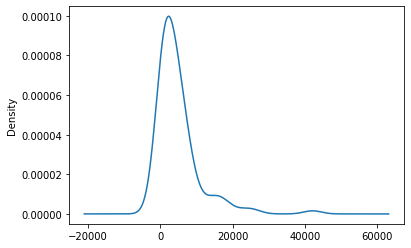

In [82]:
# 2. Group beer styles based on binning:

# Get the beer_style value counts
beer_style_counts = beer_df.beer_style.value_counts()

# Visualize the value counts
beer_style_counts.plot.density()

In [83]:
# Determine which values to replace
replace_beer_styles = list(beer_style_counts[beer_style_counts < 10000].index)

# Replace in DataFrame
for beer_style_binned in replace_beer_styles:
    beer_df.beer_style_binned = beer_df.beer_style_binned.replace(beer_style_binned,"Other")
    
# Check to make sure binning was successful
pd.set_option("display.max_rows", None) #allows you to see all results
beer_df.beer_style_binned.value_counts()


Other                               293699
American IPA                         42097
American Double / Imperial IPA       25786
American Double / Imperial Stout     23194
American Pale Ale (APA)              18920
American Amber / Red Ale             17605
Russian Imperial Stout               16969
American Porter                      15476
Belgian Strong Dark Ale              15320
Fruit / Vegetable Beer               14633
Witbier                              13225
Tripel                               11551
Name: beer_style_binned, dtype: int64

In [84]:
beer_df.head()

#The "beer_style" column containing binned beer styles would be our target vector.

,beer_ABV,beer_style,review_appearance,review_palette,review_overall,review_taste,review_aroma,beer_style_manually_grouped,beer_style_binned
0,5.0,Hefeweizen,2.5,2.0,1.5,1.5,1.5,Other,Other
1,6.2,English Strong Ale,3.0,2.5,3.0,3.0,3.0,Ale,Other
2,6.5,Foreign / Export Stout,3.0,2.5,3.0,3.0,3.0,Stout,Other
3,5.0,German Pilsener,3.5,3.0,3.0,2.5,3.0,Pilsner,Other
4,7.7,American Double / Imperial IPA,4.0,4.5,4.0,4.0,4.5,Ale,American Double / Imperial IPA


In [85]:
# 3. Decide on beer_style groupings based on cluster analysis:

print(clustered_df.shape)
clustered_df.head(10)

#The "Class" column would be our target vector.


(508475, 11)


,beer_ABV,review_appearance,review_palette,review_overall,review_taste,review_aroma,PC 1,PC 2,PC 3,beer_style,Class
0,5.0,2.5,2.0,1.5,1.5,1.5,6.731175,0.635574,-0.326908,Hefeweizen,6
1,6.2,3.0,2.5,3.0,3.0,3.0,3.040082,0.088104,0.435684,English Strong Ale,3
2,6.5,3.0,2.5,3.0,3.0,3.0,3.012033,0.214500,0.463295,Foreign / Export Stout,3
3,5.0,3.5,3.0,3.0,2.5,3.0,2.851409,-0.257311,-0.483844,German Pilsener,1
4,7.7,4.0,4.5,4.0,4.0,4.5,-1.308323,0.147005,0.232782,American Double / Imperial IPA,4
5,4.7,3.5,3.5,3.0,3.0,3.5,1.890992,-0.490289,-0.242581,Herbed / Spiced Beer,3
6,4.7,3.5,3.5,3.5,4.0,4.0,0.573104,-0.938295,0.295053,Herbed / Spiced Beer,5
7,4.7,3.5,2.5,3.0,2.0,3.5,3.206626,-0.447056,-0.412057,Herbed / Spiced Beer,1
8,4.7,3.5,3.0,4.0,3.5,4.0,0.919320,-1.148925,0.412142,Herbed / Spiced Beer,5
9,4.7,5.0,3.5,4.5,4.0,4.0,-1.006172,-1.249811,-1.527743,Herbed / Spiced Beer,4


### 10. Re-run our decision tree using these three grouping methods and compare accuacy scores

In [87]:
# 1. using manual groupings as the target vector:

# Define features set
X = beer_df.copy()
X = X.drop(columns=["beer_style", "beer_style_manually_grouped", "beer_style_binned"], axis=1)
X.head()

# Define target vector
y = beer_df["beer_style_manually_grouped"].values.reshape(-1, 1)
y[:5]

# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [88]:
# Creating the decision tree classifier instance
model = tree.DecisionTreeClassifier()

# Fitting the model
model = model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = model.predict(X_test_scaled)
len(predictions)

127119

In [90]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

# Displaying results
print("Confusion Matrix")
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix
Accuracy Score : 0.5375671614786145
Classification Report
              precision    recall  f1-score   support

         Ale       0.57      0.74      0.64     56775
       Lager       0.52      0.45      0.48      8871
       Other       0.50      0.42      0.46     37253
     Pilsner       0.24      0.08      0.12      3195
      Porter       0.30      0.11      0.16      5610
       Stout       0.55      0.35      0.43     15415

    accuracy                           0.54    127119
   macro avg       0.44      0.36      0.38    127119
weighted avg       0.52      0.54      0.52    127119



In [93]:
# 2. using binned groups as the target vector:

# Define features set
X = beer_df.copy()
X = X.drop(columns=["beer_style", "beer_style_manually_grouped", "beer_style_binned"], axis=1)
X.head()

# Define target vector
y = beer_df["beer_style_binned"].values.reshape(-1, 1)
y[:5]

# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [94]:
# Creating the decision tree classifier instance
model = tree.DecisionTreeClassifier()

# Fitting the model
model = model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = model.predict(X_test_scaled)
len(predictions)

127119

In [95]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

# Displaying results
print("Confusion Matrix")
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix
Accuracy Score : 0.5922560750163233
Classification Report
                                  precision    recall  f1-score   support

        American Amber / Red Ale       0.21      0.10      0.14      4458
  American Double / Imperial IPA       0.36      0.34      0.35      6402
American Double / Imperial Stout       0.54      0.48      0.51      5832
                    American IPA       0.51      0.46      0.48     10448
         American Pale Ale (APA)       0.34      0.19      0.25      4695
                 American Porter       0.21      0.09      0.12      3818
         Belgian Strong Dark Ale       0.27      0.22      0.24      3815
          Fruit / Vegetable Beer       0.39      0.22      0.28      3673
                           Other       0.67      0.83      0.74     73569
          Russian Imperial Stout       0.37      0.22      0.27      4225
                          Tripel       0.34      0.14      0.19      2894
                         Witbier    

In [118]:
# 2. Using the classes found from our k-Means analysis
print(clustered_df.shape)
clustered_df.head(10)

(508475, 11)


,beer_ABV,review_appearance,review_palette,review_overall,review_taste,review_aroma,PC 1,PC 2,PC 3,beer_style,Class
0,5.0,2.5,2.0,1.5,1.5,1.5,6.731175,0.635574,-0.326908,Hefeweizen,5
1,6.2,3.0,2.5,3.0,3.0,3.0,3.040082,0.088104,0.435684,English Strong Ale,8
2,6.5,3.0,2.5,3.0,3.0,3.0,3.012033,0.214500,0.463295,Foreign / Export Stout,8
3,5.0,3.5,3.0,3.0,2.5,3.0,2.851409,-0.257311,-0.483844,German Pilsener,8
4,7.7,4.0,4.5,4.0,4.0,4.5,-1.308323,0.147005,0.232782,American Double / Imperial IPA,0
5,4.7,3.5,3.5,3.0,3.0,3.5,1.890992,-0.490289,-0.242581,Herbed / Spiced Beer,8
6,4.7,3.5,3.5,3.5,4.0,4.0,0.573104,-0.938295,0.295053,Herbed / Spiced Beer,2
7,4.7,3.5,2.5,3.0,2.0,3.5,3.206626,-0.447056,-0.412057,Herbed / Spiced Beer,8
8,4.7,3.5,3.0,4.0,3.5,4.0,0.919320,-1.148925,0.412142,Herbed / Spiced Beer,2
9,4.7,5.0,3.5,4.5,4.0,4.0,-1.006172,-1.249811,-1.527743,Herbed / Spiced Beer,7


In [119]:
# Define features set
X = clustered_df.copy()
X = X.drop(columns=["PC 1", "PC 2", "PC 3", "beer_style", "Class"], axis=1)
X.head()

# Define target vector
y = clustered_df["Class"].values.reshape(-1, 1)
y[:5]

# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [120]:
# Creating the decision tree classifier instance
model = tree.DecisionTreeClassifier()

# Fitting the model
model = model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = model.predict(X_test_scaled)
len(predictions)

127119

In [121]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

# Displaying results
print("Confusion Matrix")
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix
Accuracy Score : 0.9905128265640856
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     20529
           1       0.97      0.97      0.97      6494
           2       0.99      0.99      0.99     15451
           3       1.00      0.99      0.99     13807
           4       0.99      0.99      0.99     15606
           5       0.97      0.97      0.97      4277
           6       0.99      0.99      0.99     11765
           7       1.00      1.00      1.00     26577
           8       0.98      0.98      0.98     12613

    accuracy                           0.99    127119
   macro avg       0.99      0.99      0.99    127119
weighted avg       0.99      0.99      0.99    127119



### 12. Which grouping of beer_style yeilds the highest accuracy score?

Using the clusters predcted by out k-means model as the targeet vector yeilded the highest accuracy score! woot!